
## Tiny Course Load Risk — Model Dev Notebook

This notebook does:
* Load OULAD CSVs (from `backend/data/raw/`).
* Build a **term-level** training table with simple, explainable features.
* Train a **Logistic Regression** baseline.
* Evaluate precision/recall, draw a PR curve, and pick a threshold.
* Save model artifacts to `backend/model_store/baseline_v1/` and an evaluation CSV to `evals/`.


In [5]:

# If you're in your repo root, set these so the paths resolve.
# You can also run this notebook from backend/ by adjusting ROOT accordingly.

from pathlib import Path

import json, datetime as dt, joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import shap


from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score

from pathlib import Path



In [6]:
# Paths
from pathlib import Path

BASE = Path("Course-Load-Risk") 
DATA_RAW       = BASE / "backend" / "data" / "raw"
DATA_PROCESSED = BASE / "backend" / "data" / "processed"
MODEL_DIR      = BASE / "backend" / "model_store" / "baseline_v1"
EVALS_DIR      = BASE / "evals"


for p in (DATA_PROCESSED, MODEL_DIR, EVALS_DIR):
    p.mkdir(parents=True, exist_ok=True)


print("BASE        :", BASE.resolve())
print("DATA_RAW    :", DATA_RAW.resolve())
print("MODEL_DIR   :", MODEL_DIR.resolve())
print("EVALS_DIR   :", EVALS_DIR.resolve())


BASE        : /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk
DATA_RAW    : /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/data/raw
MODEL_DIR   : /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/model_store/baseline_v1
EVALS_DIR   : /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/evals


## Load OULAD CSVs & quick Exploratory Data Analysis

In [7]:
courses = pd.read_csv(DATA_RAW/'courses.csv')                 # code_module, code_presentation, etc.
studentInfo = pd.read_csv(DATA_RAW/'studentInfo.csv')         # id_student, studied_credits, final_result, ...

print(courses.head(3))
print(studentInfo.head(3))
print(studentInfo['final_result'].value_counts(dropna=False))

# Join minimal course metadata we need
df = studentInfo.merge(courses, on=['code_module','code_presentation'], how='left')
df.head(3)



  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  
2               60          Y    Withdrawn  
fi

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,268


## Define mapping, features, and label engineering

In [9]:
df['term_key'] = df['code_presentation'].astype(str)

first_letter = df['code_module'].astype('string').str[0].str.upper()
letter_to_level = {'A':100, 'B':200, 'C':300, 'D':400}
df['level_num'] = first_letter.map(letter_to_level).astype('float')  

df['is_stem'] = df['code_module'].astype('string').str.lower()\
               .str.contains('math|stat|comput|physics|chem|eng|tech', regex=True, na=False)

course_counts = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(n_courses=('code_module','count'))
)

term_duration = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(term_length_days=('module_presentation_length','max'))  
)

avg_level = ('level_num', lambda s: (s/100.0).mean())

feats = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(
        total_credits      = ('studied_credits','sum'),
        upper_level_count  = ('level_num',      lambda s: (s >= 300).sum()),
        avg_level          = ('level_num',      lambda s: (s/100.0).mean()),
        stem_course_count  = ('is_stem',        'sum'),
      )
)

feats = (feats
         .merge(course_counts, on=['id_student','term_key'], how='left')
         .merge(term_duration, on=['id_student','term_key'], how='left'))


feats['ou_course_equiv'] = feats['total_credits'] // 15.0

label = (
    df.assign(over=df['final_result'].isin(['Fail','Withdrawn']))
      .groupby(['id_student','term_key'], as_index=False)['over']
      .max()
      .rename(columns={'over':'overload_risk'})
      .astype({'overload_risk':'int64'})
)

pts_map = {'distinction':4.0, 'pass':3.0, 'fail':1.0, 'withdrawn':0.0}
df['outcome_pts'] = df['final_result'].astype('string').str.lower().map(pts_map)

term_out = (df.groupby(['id_student','term_key'], as_index=False)
              .agg(term_gpa=('outcome_pts','mean'),
                   term_fails=('final_result', lambda s:(s.isin(['Fail','Withdrawn'])).sum()))
            .sort_values(['id_student','term_key']))
term_out['gpa_last_term']   = term_out.groupby('id_student')['term_gpa'].shift(1)
term_out['past_fail_count'] = term_out.groupby('id_student')['term_fails'].cumsum().shift(1)

training_table = (feats.merge(label, on=['id_student','term_key'])
                        .merge(term_out[['id_student','term_key','gpa_last_term','past_fail_count']],
                               on=['id_student','term_key'], how='left'))


training_table['ou_course_equiv'] = pd.to_numeric(training_table['total_credits'], errors='coerce') / 30.0

training_path = DATA_PROCESSED/'training_table.csv'
training_table.to_csv(training_path, index=False)
print("Saved:", training_path, "rows=", len(training_table))
training_table.head()


Saved: Course-Load-Risk/backend/data/processed/training_table.csv rows= 31512


,id_student,term_key,total_credits,upper_level_count,avg_level,stem_course_count,n_courses,term_length_days,ou_course_equiv,overload_risk,gpa_last_term,past_fail_count
0,3733,2013J,60,1,4.0,0,1,261,2.0,1,NaN,NaN
1,6516,2014J,60,0,1.0,0,1,269,2.0,0,NaN,1.0
2,8462,2013J,90,1,4.0,0,1,261,3.0,1,NaN,0.0
3,8462,2014J,60,1,4.0,0,1,262,2.0,1,0.0,1.0
4,11391,2013J,240,0,1.0,0,1,268,8.0,0,NaN,2.0


## Data Preprocessing

In [10]:
from sklearn.pipeline import make_pipeline

TARGET = 'overload_risk'
FEATURES = [
    'n_courses',
    'total_credits',
    'upper_level_count',
    'avg_level',
    'stem_course_count',
    'gpa_last_term',
    'past_fail_count',
    'ou_course_equiv'
]



X = training_table[FEATURES]
y = training_table[TARGET].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_features = FEATURES
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ],
    remainder='drop', 
    verbose_feature_names_out=False 
)

X_train.head()


,n_courses,total_credits,upper_level_count,avg_level,stem_course_count,gpa_last_term,past_fail_count,ou_course_equiv
14811,1,300,0,NaN,0,NaN,0.0,10.0
10235,1,90,1,3.0,0,NaN,0.0,3.0
31368,1,30,0,NaN,0,NaN,1.0,1.0
6092,1,60,1,3.0,0,NaN,0.0,2.0
29455,1,60,1,4.0,0,NaN,0.0,2.0


## Baseline Dummy Classifier Scores

In [11]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
p_dummy = dummy.predict_proba(X_test)[:,1]
print("Dummy accuracy:", (dummy.predict(X_test) == y_test).mean())
print("Dummy AP:", average_precision_score(y_test, p_dummy))

Dummy accuracy: 0.5267834475755268
Dummy AP: 0.5267834475755268


## Train Logistic Regression baseline

In [12]:
model = make_pipeline(
    preprocessor,
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {     
    "ap": "average_precision",
    "precision": "precision",
    "recall": "recall"
}

cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
print("CV average precision:", cv_res["test_ap"].mean())
print("CV Precision:", cv_res["test_precision"].mean())
print("CV Recall:", cv_res["test_recall"].mean())

model.fit(X_train, y_train)

CV average precision: 0.626585407605054
CV Precision: 0.603207219263544
CV Recall: 0.5321234838994678


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


## Hyperparameter Tuning

In [13]:
param_grid = {
    "logisticregression__C": [0.05, 0.1, 0.5, 1, 2, 5, 10],     
}

gs = GridSearchCV(
    estimator=model,                
    param_grid=param_grid,
    scoring="average_precision",    
    cv=cv,
    n_jobs=-1,
    refit=True                      
)
gs.fit(X_train, y_train)


best_model = gs.best_estimator_
print("Best params:", gs.best_params_)
print("CV AP (best):", gs.best_score_)

Best params: {'logisticregression__C': 0.5}
CV AP (best): 0.6266469638824725


In [ ]:
proba_oof = cross_val_predict(
    best_model, X_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)

# Fit once so we can read class ordering safely
best_model.fit(X_train, y_train)
classes = best_model.named_steps["logisticregression"].classes_
pos_label = 1
pos_idx = list(classes).index(pos_label)

pred_oof = proba_oof[:, pos_idx]
print("classes:", classes, "| pos_idx:", pos_idx)

# Quick distribution sanity check (optional but VERY helpful)
print("OOF prob min/25/50/75/max:",
      float(np.min(pred_oof)),
      float(np.quantile(pred_oof, 0.25)),
      float(np.quantile(pred_oof, 0.50)),
      float(np.quantile(pred_oof, 0.75)),
      float(np.max(pred_oof)))

classes: [0 1] | pos_idx: 1
OOF prob min/25/50/75/max: 0.21473317871395092 0.4374622191937772 0.48303171202941453 0.5334592112451094 0.9931092747991311


In [ ]:
prec, rec, thr = precision_recall_curve(y_train, pred_oof)
f1 = 2*prec*rec/(prec+rec + 1e-9)

best_i = int(np.nanargmax(f1[:-1]))  # thr aligns with f1[:-1]
thr_high = float(thr[best_i])
binary_threshold = thr_high
print("thr_high (best F1 on OOF):", thr_high)
print("best F1:", float(f1[best_i]))

thr_high (best F1 on OOF): 0.35022706552681215
best F1: 0.6911895740624616


## Precision Recall Curve plot

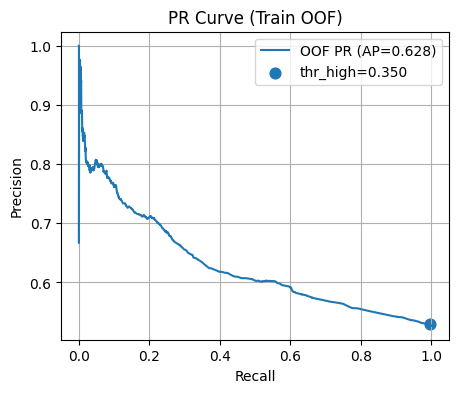

In [16]:
ap = average_precision_score(y_train, pred_oof)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"OOF PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Curve (Train OOF)")
plt.grid(True)

# Mark the chosen threshold point on the curve
plt.scatter(rec[best_i], prec[best_i], s=60, label=f"thr_high={thr_high:.3f}")
plt.legend()
plt.show()

In [27]:
low_target = 0.60   # 60% low risk
high_target = 0.20  # 20% high risk (top 20%)
# medium is the remaining 20%

thr_low  = float(np.quantile(pred_oof, low_target))
thr_high = float(np.quantile(pred_oof, 1 - high_target))

print("Band thresholds (quantiles): thr_low=", thr_low, "thr_high=", thr_high)

low_share  = float(np.mean(pred_oof < thr_low))
med_share  = float(np.mean((pred_oof >= thr_low) & (pred_oof < thr_high)))
high_share = float(np.mean(pred_oof >= thr_high))
print(f"Shares → low: {low_share:.3f}, medium: {med_share:.3f}, high: {high_share:.3f}")

Band thresholds (quantiles): thr_low= 0.5261355045458975 thr_high= 0.5421242901565694
Shares → low: 0.599, medium: 0.199, high: 0.202


In [28]:
p_test = best_model.predict_proba(X_test)[:, pos_idx]

test_ap   = float(average_precision_score(y_test, p_test))
test_prec = float(precision_score(y_test, p_test >= thr_high, zero_division=0))
test_rec  = float(recall_score(y_test,  p_test >= thr_high, zero_division=0))
test_f1   = float(f1_score(y_test,      p_test >= thr_high, zero_division=0))

print("Test AP:", test_ap)
print("Test Precision at thr_high:", test_prec)
print("Test Recall atthr_high:", test_rec)
print("Test F1 at thr_high:", test_f1)

Test AP: 0.6365906626091073
Test Precision at thr_high: 0.6954787234042553
Test Recall atthr_high: 0.2520481927710843
Test F1 at thr_high: 0.37000353731871244


## Save artifacts to model_store/baseline_v1 and evals/

In [ ]:
MODEL_TAG = "baseline_v1" 

ROOT = Path("Course-Load-Risk")
MODEL_DIR = ROOT/"backend"/"model_store"/MODEL_TAG
EVALS_DIR = ROOT/"evals"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
EVALS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, MODEL_DIR/"model.joblib")

(MODEL_DIR/"feature_names.json").write_text(json.dumps(FEATURES, indent=2))

pd.DataFrame([{
    "model_tag": MODEL_TAG,
    "test_avg_precision": float(test_ap),
    "test_precision_at_thr": float(test_prec),
    "test_recall_at_thr": float(test_rec),
    "test_f1_at_thr": float(test_f1),
    "threshold": [ float(thr_high), float(thr_low)],
    "n_test": int(len(y_test)),
}]).to_csv(EVALS_DIR/f"eval_{MODEL_TAG}.csv", index=False)

meta = {
    "model_tag": MODEL_TAG,
    "trained_at": dt.datetime.utcnow().isoformat()+"Z",
    "algo": type(best_model.named_steps[list(best_model.named_steps.keys())[-1]]).__name__,
    "decision_threshold": float(binary_threshold = thr_high
),   # binary cutoff
    "thresholds": {                              # UI bands
        "low": float(thr_low),
        "high": float(thr_high),
    },
    "threshold_policy": "bands=quantiles" ,  # or "bands=buffer_around_decision"
    "features_count": len(FEATURES),
    "sklearn_version": __import__("sklearn").__version__,
}

(MODEL_DIR/"meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved artifacts to:", MODEL_DIR)
print("Saved eval CSV to  :", EVALS_DIR/f"eval_{MODEL_TAG}.csv")

Saved artifacts to: Course-Load-Risk/backend/model_store/baseline_v1
Saved eval CSV to  : Course-Load-Risk/evals/eval_baseline_v1.csv


/var/folders/z4/4803pm_d5gs3wzcdfkb6f1cw0000gn/T/ipykernel_34802/2983472787.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at": dt.datetime.utcnow().isoformat()+"Z",


## Summary
The binary threshold found from the precision recall curve sits at around 0.35. Now when adding a new class (medium risk), we find that the low threshold is at around 0.347, which is a very small range for medium risk data to fit in. This means that this area is quite dense and is producing such thresholding due to the distribution. So I added quantile risk bands to guarantee that the medium risk class exists and will be predicted. 